# Task 1: Symptom Co-occurrence Patterns

Goal: Find which symptom often appear together in diseases.

Dataset: disease-symptom-description-dataset

## 1. Loading Data

Data is loaded in using kagglehub from https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset

In [ ]:
import kagglehub

# Download latest version
ds_path = kagglehub.dataset_download("itachi9604/disease-symptom-description-dataset")

print("Path to dataset files:", ds_path)

import os

print(os.listdir(ds_path))

Using Colab cache for faster access to the 'disease-symptom-description-dataset' dataset.
Path to dataset files: /kaggle/input/disease-symptom-description-dataset
['symptom_Description.csv', 'Symptom-severity.csv', 'symptom_precaution.csv', 'dataset.csv']


In [ ]:
import pandas as pd

ds_df = pd.read_csv(ds_path + "/dataset.csv")
ds_df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import warnings
warnings.filterwarnings("ignore")


## 2. Preprocessing the Data

Each disease -> One basket
Each symptom -> One item

Cleaning dataset:
- Lowercase all symptom names
- Remove NaN/ Empty cells
- Replace synonyms

In [ ]:
# Convert to lowercase and clean
ds_df = ds_df.applymap(lambda x: str(x).strip().lower() if pd.notnull(x) else None)

# Melt into disease-symptom pairs
records = ds_df.melt(id_vars=["Disease"], value_name="Symptom") \
             .dropna(subset=["Symptom"]) \
             .drop_duplicates()

# Group by disease into baskets
transactions = records.groupby("Disease")["Symptom"].apply(list).tolist()


## 3. Prepare for Apriori

One-hot encoded dataframe is needed where each symptom is a column (1 = present, 0 = absent)

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)
basket_df.head()


,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


## Running Apriori Algorithm

Apriori algoritm is ran using mlxtend.frequent_patterns library

Parameters:
- min_support: adjust higher/lower depending on data size
- metric: can use "confidence", "lift", or "support"

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Find frequent itemsets (symptom combinations)
frequent_itemsets = apriori(basket_df, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

frequent_itemsets.sort_values("support", ascending=False).head(10)
rules.sort_values("lift", ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
9304,"(joint_pain, yellowing_of_eyes)","(dark_urine, yellowish_skin, vomiting, nausea,...",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
9299,"(joint_pain, yellowish_skin)","(dark_urine, yellowing_of_eyes, vomiting, naus...",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
9282,"(joint_pain, abdominal_pain, vomiting)","(dark_urine, yellowing_of_eyes, yellowish_skin...",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
9276,"(joint_pain, yellowing_of_eyes, abdominal_pain)","(dark_urine, yellowish_skin, vomiting, nausea,...",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
3480,"(joint_pain, abdominal_pain)","(dark_urine, yellowing_of_eyes, vomiting)",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
9275,"(joint_pain, yellowing_of_eyes, loss_of_appetite)","(dark_urine, yellowish_skin, vomiting, nausea,...",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
7079,"(cough, malaise, fatigue, high_fever)","(chills, chest_pain)",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
7077,"(cough, chills, malaise, high_fever)","(fatigue, chest_pain)",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
7076,"(cough, chills, fatigue, high_fever)","(malaise, chest_pain)",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0
5126,"(joint_pain, yellowing_of_eyes)","(dark_urine, loss_of_appetite, vomiting)",0.073171,0.073171,0.073171,1.0,13.666667,1.0,0.067817,inf,1.0,1.0,1.0,1.0


## Analyse & Visualise results

Plotting top frequent itemsets

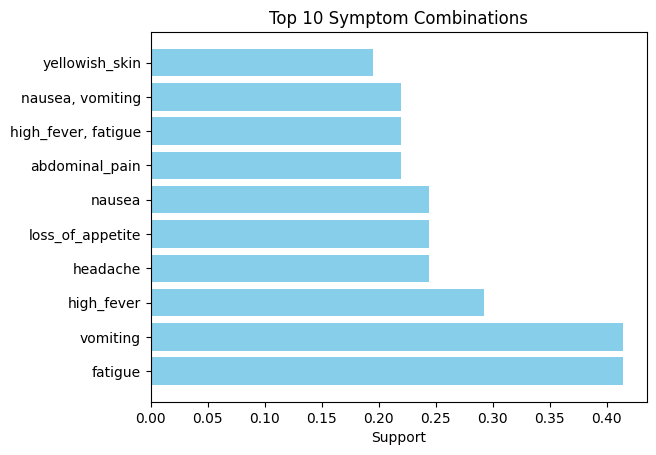

In [ ]:
import matplotlib.pyplot as plt

top = frequent_itemsets.nlargest(10, 'support')
plt.barh(range(len(top)), top['support'], color='skyblue')
plt.yticks(range(len(top)), top['itemsets'].apply(lambda x: ', '.join(x)))
plt.xlabel('Support')
plt.title('Top 10 Symptom Combinations')
plt.show()


Single symptoms like "fatigue", "vomiting" has the highest frequencies.
Combination symptoms like {high_fever, fatigue}, {nausea, vomiting} have the highest frequencies among the combinations

## Network graph
to show which symptoms tend to occur together.

Takes in only top 30 combinations

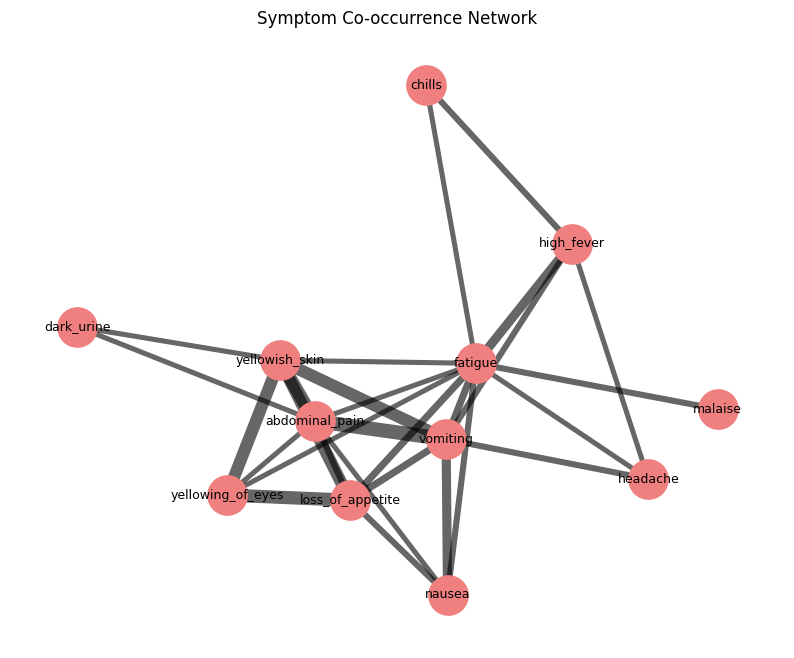

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

multi_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
filtered_itemsets = multi_itemsets.nlargest(30, 'support')

G = nx.Graph()

for _, row in filtered_itemsets.iterrows():
    items = list(row['itemsets'])
    support = row['support']
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if G.has_edge(items[i], items[j]):
                G[items[i]][items[j]]['weight'] += support
            else:
                G.add_edge(items[i], items[j], weight=support)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)  # layout
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_color='lightcoral', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos,
                       edgelist=[(u, v) for u, v, d in edges],
                       width=[d['weight'] * 30 for (u, v, d) in edges],
                       alpha=0.6)

plt.title("Symptom Co-occurrence Network")
plt.axis('off')
plt.show()


# Task 2: Cancer Feature Pattern Mining

Goal: Identify patterns in Breast Cancer Wisconsin Diagnostic dataset that distinguish malignant vs. benign cases

Dataset: Breast Cancer Wisconsin Diagnostic dataset

## Loading Dataset

Loaded Breast Cancer dataset from https://www.kaggle.com/datasets/erdemtaha/cancer-data using kaggle API

In [ ]:
!pip install prefixspan

In [ ]:
import kagglehub

# Download latest version
bc_path = kagglehub.dataset_download("erdemtaha/cancer-data")

print("Path to dataset files:", bc_path)

print(os.listdir(bc_path))

Using Colab cache for faster access to the 'cancer-data' dataset.
Path to dataset files: /kaggle/input/cancer-data
['Cancer_Data.csv']


In [ ]:
bc_df = pd.read_csv(bc_path + "/Cancer_Data.csv")
bc_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Preprocessing

Drop id as it is not required in analysis.
Diagnosis is encoded as numeric values with 'Benign' as '0' and 'Malignant' as '1'.
Features are also standardized using StandardScaler().

In [ ]:
from sklearn.preprocessing import StandardScaler

bc_df = bc_df.drop(columns=["id", "Unnamed: 32"], errors="ignore")
y = bc_df["diagnosis"]
X = bc_df.drop(columns=["diagnosis"])

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled["diagnosis"] = y


## Discretise Features

Turn continuous values into "low/medium/high" bins so they can be treated categorically instead of numerically. This allows us to check sensitivity layer using "strategy = 'uniform'" or 'kmeans'.

KBinsDiscretizer takes all the continuous numeric features (like radius_mean, area_worst, etc) and splits each features into 3 bins.
Strategy='quantile' means each bin will roughly contain the same number of samples, not equal-width intervals.


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
X_binned = pd.DataFrame(
    binner.fit_transform(X), columns=X.columns
).astype(int)

# Map 0,1,2 -> labels
label_map = {0: 'low', 1: 'medium', 2: 'high'}
X_cat = X_binned.replace(label_map)
X_cat["diagnosis"] = y


In [ ]:
def feature_sequence(row, top_k=5):
    row = row.drop("diagnosis")
    ranked = row[row == 'high'].index.tolist()  # only “high” features
    return ranked[:top_k]

seq_df = X_cat.copy()
seq_df["sequence"] = seq_df.apply(feature_sequence, axis=1)
seq_df = seq_df[["diagnosis", "sequence"]]
seq_df.head()


,diagnosis,sequence
0,M,"[radius_mean, perimeter_mean, area_mean, smoot..."
1,M,"[radius_mean, perimeter_mean, area_mean, conca..."
2,M,"[radius_mean, texture_mean, perimeter_mean, ar..."
3,M,"[smoothness_mean, compactness_mean, concavity_..."
4,M,"[radius_mean, perimeter_mean, area_mean, compa..."


PrefixSpan algorithm reveals distinct feature-rankling patterns between malignant and benign cases. Malignant samples consistently contained sequences dominated by size and boundary related irregularities such as radius_mean, perimeter_mean and area_mean.

In [ ]:
from prefixspan import PrefixSpan

# Separate by diagnosis
malignant_seq = seq_df[seq_df["diagnosis"]=="M"]["sequence"].tolist()
benign_seq    = seq_df[seq_df["diagnosis"]=="B"]["sequence"].tolist()

# Run PrefixSpan to find frequent subsequences
ps_m = PrefixSpan(malignant_seq)
patterns_m = ps_m.frequent(20)  # min_support=20 patients

ps_b = PrefixSpan(benign_seq)
patterns_b = ps_b.frequent(20)


In [ ]:
print("Malignant Patterns:")
for sup, pat in sorted(patterns_m, key=lambda x: -x[0])[:10]:
    print(f"{pat}  (support={sup})")

print("\nBenign Patterns:")
for sup, pat in sorted(patterns_b, key=lambda x: -x[0])[:10]:
    print(f"{pat}  (support={sup})")


Malignant Patterns:
['perimeter_mean']  (support=169)
['radius_mean']  (support=167)
['area_mean']  (support=167)
['radius_mean', 'perimeter_mean']  (support=166)
['radius_mean', 'area_mean']  (support=166)
['radius_mean', 'perimeter_mean', 'area_mean']  (support=165)
['perimeter_mean', 'area_mean']  (support=165)
['texture_mean']  (support=121)
['smoothness_mean']  (support=108)
['compactness_mean']  (support=107)

Benign Patterns:
['texture_se']  (support=113)
['fractal_dimension_mean']  (support=110)
['smoothness_se']  (support=97)
['symmetry_mean']  (support=83)
['smoothness_mean']  (support=82)
['symmetry_se']  (support=75)
['texture_mean']  (support=70)
['smoothness_mean', 'fractal_dimension_mean']  (support=54)
['fractal_dimension_mean', 'smoothness_se']  (support=47)
['texture_se', 'smoothness_se']  (support=47)


Each line represents frequent sequential pattern (ordered combination of features that often appear as 'high' for many patients for the same diagnosis group)

Pattern: Sequence of features frequently ranked as high

Support: Number of patients in that group whose top liust contains that pattern

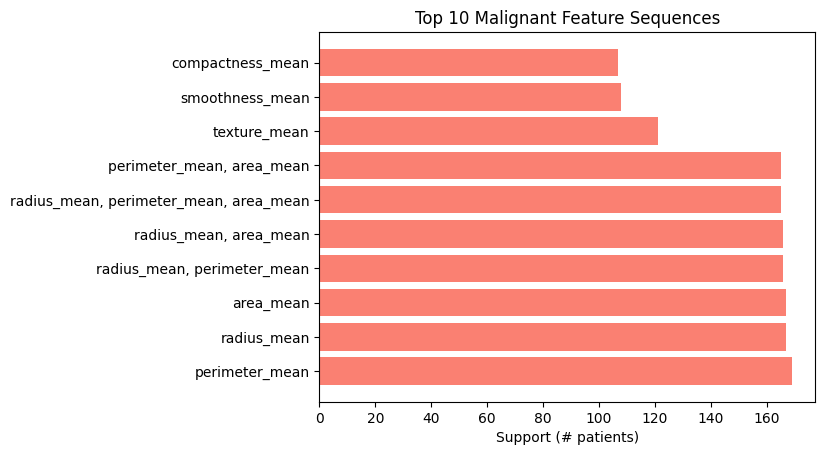

In [ ]:
import matplotlib.pyplot as plt

top_m = sorted(patterns_m, key=lambda x: -x[0])[:10]
plt.barh(
    [', '.join(p) for (_, p) in top_m],
    [s for (s, _) in top_m],
    color='salmon'
)
plt.title("Top 10 Malignant Feature Sequences")
plt.xlabel("Support (# patients)")
plt.show()


radius_mean, perimeter_mean and area_mean are the most dominant 'high' feature.
-> Size-related measurements of the tumor

Joint occurances of them indicates that malignant tumors tend to have larger and more irregular cell structures.

texture_mean, smoothness_mean, compactness_mean appear with lower support but still frequently. This means that surface irregularity and rough boundaries are also frequent in malignant morphology.



### Different binning

Binning the features using different strategy can give us different results. Strategies such as 'Quantile', 'Uniform', 'K-means' can all give different results.

Quantille: Divides features values into equal-frequency bins (Same size bins)

Uniform: Divides the value range into equal-width bins

K-means: Uses clusterings to form bins with minimal within-cluster variance

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from prefixspan import PrefixSpan

strategies = ['quantile', 'uniform', 'kmeans']
results = {}

for strat in strategies:
    binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy=strat)
    X_binned = pd.DataFrame(binner.fit_transform(X), columns=X.columns).astype(int)
    X_cat = X_binned.replace({0:'low',1:'medium',2:'high'})
    X_cat['diagnosis'] = y

    def feature_sequence(row, top_k=5):
        row = row.drop("diagnosis")
        ranked = row[row == 'high'].index.tolist()
        return ranked[:top_k]

    seq_df = X_cat.copy()
    seq_df["sequence"] = seq_df.apply(feature_sequence, axis=1)
    seq_df = seq_df[["diagnosis", "sequence"]]

    mal_seq = seq_df[seq_df["diagnosis"]=="M"]["sequence"].tolist()
    ben_seq = seq_df[seq_df["diagnosis"]=="B"]["sequence"].tolist()

    ps_m = PrefixSpan(mal_seq)
    ps_b = PrefixSpan(ben_seq)

    top_m = ps_m.frequent(20)
    top_b = ps_b.frequent(20)

    results[strat] = {
        "malignant": top_m[:5],
        "benign": top_b[:5]
    }

# Display comparative results
for strat, res in results.items():
    print(f"\n=== Strategy: {strat.upper()} ===")
    print("Top Malignant Patterns:")
    for sup, pat in res["malignant"]:
        print(f"{pat} (support={sup})")
    print("Top Benign Patterns:")
    for sup, pat in res["benign"]:
        print(f"{pat} (support={sup})")



=== Strategy: QUANTILE ===
Top Malignant Patterns:
['radius_mean'] (support=167)
['radius_mean', 'perimeter_mean'] (support=166)
['radius_mean', 'perimeter_mean', 'area_mean'] (support=165)
['radius_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean'] (support=78)
['radius_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean'] (support=36)
Top Benign Patterns:
['smoothness_se'] (support=97)
['smoothness_se', 'smoothness_worst'] (support=23)
['smoothness_se', 'symmetry_se'] (support=36)
['smoothness_worst'] (support=41)
['smoothness_mean'] (support=82)

=== Strategy: UNIFORM ===
Top Malignant Patterns:
['concave points_worst'] (support=69)
['smoothness_worst'] (support=21)
['radius_mean'] (support=22)
['radius_mean', 'perimeter_mean'] (support=20)
['perimeter_mean'] (support=22)
Top Benign Patterns:

=== Strategy: KMEANS ===
Top Malignant Patterns:
['radius_mean'] (support=107)
['radius_mean', 'perimeter_mean'] (support=99)
['radius_mean', 'perimeter_mean', 's

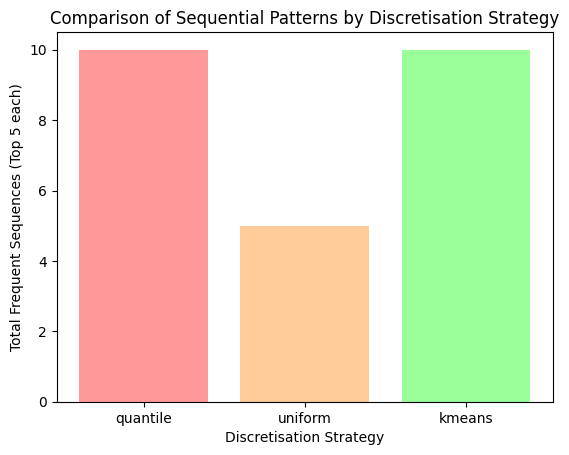

In [ ]:
import matplotlib.pyplot as plt

counts = {s: len(results[s]['malignant']) + len(results[s]['benign']) for s in strategies}
plt.bar(counts.keys(), counts.values(), color=['#ff9999','#ffcc99','#99ff99'])
plt.xlabel("Discretisation Strategy")
plt.ylabel("Total Frequent Sequences (Top 5 each)")
plt.title("Comparison of Sequential Patterns by Discretisation Strategy")
plt.show()


### Quantile
Malignant: Dominated by radius_mean, perimeter_mean, area_mean with support of around 160 patients. Adding smoothness_mean and compactness_mean slightly reduces support but shows ahpe irregularity.

Quantile binning captures global ranking structure and clearly shows the separation between size-based and smoothness-based patterns

### Uniform

Malignant: Only moderate supports (20-70). concave_points_worst and radius_mean still appear but the overall patterns are weaker.

Uniform binning loses granualrity where the data are unevenly distributed. Extreme values dominate one bin and reduces the stability of frequent sequences.

### K-Means

Malignant: Again radius_mean + perimeter_mean combinations dominate (support of arround 160)

K-Means binning reproduce similar key features as Quantile, proving the pattern robustness while offering better grouping of outliers.

# Task 3: Open Advanced Task

Goal: Design your own healthcare using the datasets



Privacy issues with using the patient dataset for research.

--> Synthetic Data generation
new synthetic data that resembles the healthcare data

## 3.1 Breast Cancer Dataset

### 3.1.1. CTGAN

First Synthetic dataset will be generated using CTGAN and Breast Cancer Dataset

In [ ]:
pip install ctgan

  Using cached ctgan-0.11.1-py3-none-any.whl.metadata (10 kB)
  Using cached rdt-1.18.2-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00


In [ ]:
from ctgan import CTGAN

In [ ]:
real_data = bc_df
real_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
if "id" in real_data.columns:
    real_data = real_data.drop(columns=["id"])
if "Unnamed: 32" in real_data.columns:
    real_data = real_data.drop(columns=["Unnamed: 32"])

In [ ]:
real_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
discrete_columns = [
    'diagnosis',
]

In [ ]:
ctgan = CTGAN(epochs=25, batch_size=40)
ctgan.fit(real_data, discrete_columns)

In [ ]:
synthetic_data_1 = ctgan.sample(1000)

In [ ]:
synthetic_data_1.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.250104,15.666133,109.065551,425.693679,0.098831,0.133804,0.110448,0.071835,0.190159,0.064578,...,19.959913,29.502052,118.327391,502.311649,0.124345,0.313899,0.227636,0.126280,0.282420,0.074556
std,4.466802,4.606196,30.665122,310.832516,0.017370,0.072642,0.096996,0.047242,0.032300,0.009004,...,6.178342,9.594061,39.576449,494.010775,0.031679,0.161410,0.226789,0.078053,0.075826,0.019746
min,4.994367,6.741816,42.871935,-483.029738,0.057694,-0.019090,-0.022718,-0.024703,0.112636,0.046549,...,7.553879,9.203353,43.907929,-792.889987,0.055133,0.033526,-0.221007,-0.036393,0.123662,0.023211
25%,11.057166,12.415817,89.532307,214.109033,0.086662,0.080002,0.052859,0.036123,0.166835,0.057625,...,15.752475,22.428060,93.441386,216.389289,0.100877,0.214231,0.067444,0.066603,0.227035,0.061446
50%,13.676618,15.279455,105.773544,381.811091,0.097448,0.123587,0.078076,0.057473,0.188912,0.063417,...,18.324248,28.142080,110.875999,393.343961,0.122834,0.283678,0.170338,0.121203,0.275481,0.071448
75%,16.423653,18.469550,121.726103,557.688970,0.110247,0.174801,0.142590,0.105695,0.211942,0.070782,...,23.209357,35.804151,126.383317,638.051276,0.145791,0.361148,0.319199,0.178620,0.324103,0.082583
max,30.903810,33.415089,243.833913,2115.070301,0.173865,0.378709,0.574707,0.251338,0.334556,0.088689,...,44.482193,58.030629,273.473852,4370.577069,0.233366,1.152246,1.176209,0.327604,0.608564,0.192223


In [ ]:
synthetic_data_1.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,B,9.679174,9.217521,80.755736,442.818978,0.114195,0.077228,0.146551,0.044801,0.173172,...,22.985420,15.860049,118.147271,661.510277,0.166717,0.153039,0.153170,0.128977,0.193498,0.080746
1,B,24.263528,14.501651,151.045576,603.501013,0.112948,0.288868,0.066534,0.043921,0.223022,...,27.999675,34.301730,86.591473,545.143777,0.126609,0.559477,0.056010,0.125515,0.177373,0.051449
2,B,28.662149,13.816229,56.044189,537.070382,0.088186,0.101771,0.009616,0.081999,0.231597,...,28.216229,35.294545,95.389565,90.690174,0.098843,0.247035,0.342675,0.025375,0.364399,0.072432
3,M,21.013041,12.119125,102.310653,90.374643,0.131626,0.149308,0.044591,0.017695,0.259869,...,18.218466,21.774044,106.560448,273.448040,0.174535,0.212337,0.262718,0.034767,0.182835,0.056435
4,M,23.081629,20.734234,105.733077,-158.799691,0.087449,0.082248,0.090685,0.111856,0.207982,...,17.680677,31.109310,112.777429,390.435655,0.069952,0.587891,0.230578,0.192706,0.422761,0.070940


### 3.1.2. TVAE

Synthetic data generation using TVAE

In [ ]:
pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
metadata_dict = metadata.to_dict()

In [ ]:
print(metadata_dict)

{'columns': {'diagnosis': {'sdtype': 'categorical'}, 'radius_mean': {'sdtype': 'numerical'}, 'texture_mean': {'sdtype': 'numerical'}, 'perimeter_mean': {'sdtype': 'numerical'}, 'area_mean': {'sdtype': 'numerical'}, 'smoothness_mean': {'sdtype': 'numerical'}, 'compactness_mean': {'sdtype': 'numerical'}, 'concavity_mean': {'sdtype': 'numerical'}, 'concave points_mean': {'sdtype': 'numerical'}, 'symmetry_mean': {'sdtype': 'numerical'}, 'fractal_dimension_mean': {'sdtype': 'numerical'}, 'radius_se': {'sdtype': 'numerical'}, 'texture_se': {'sdtype': 'numerical'}, 'perimeter_se': {'sdtype': 'numerical'}, 'area_se': {'sdtype': 'numerical'}, 'smoothness_se': {'sdtype': 'numerical'}, 'compactness_se': {'sdtype': 'numerical'}, 'concavity_se': {'sdtype': 'numerical'}, 'concave points_se': {'sdtype': 'numerical'}, 'symmetry_se': {'sdtype': 'numerical'}, 'fractal_dimension_se': {'sdtype': 'numerical'}, 'radius_worst': {'sdtype': 'numerical'}, 'texture_worst': {'sdtype': 'numerical'}, 'perimeter_wor

In [ ]:
from sdv.single_table import TVAESynthesizer

synthesizer = TVAESynthesizer(metadata)
synthesizer.fit(real_data)

synthetic_data_2 = synthesizer.sample(num_rows=1000)

In [ ]:
synthetic_data_2.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,13.188356,17.628350,88.543690,576.332800,0.095482,0.096482,0.076964,0.042470,0.172364,0.060636,...,15.769122,25.179580,99.285820,760.680800,0.125703,0.223796,0.257577,0.114597,0.283977,0.078994
std,2.637872,4.120128,21.442415,251.545987,0.013205,0.045812,0.066031,0.032249,0.021688,0.005029,...,4.221169,5.787417,27.042678,412.884619,0.022139,0.122737,0.187778,0.067254,0.044934,0.012730
min,7.595000,9.710000,50.280000,143.500000,0.060260,0.019380,0.000000,0.000000,0.106000,0.050310,...,7.930000,12.020000,54.650000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.579750,14.860000,73.517500,422.825000,0.085027,0.057750,0.024208,0.017940,0.156375,0.057377,...,12.867500,20.332500,81.180000,516.475000,0.111315,0.133030,0.109404,0.061120,0.255900,0.070692
50%,12.676000,16.770000,82.830000,507.250000,0.094990,0.094980,0.048884,0.029370,0.170800,0.059850,...,14.445500,25.325000,91.580000,633.100000,0.122055,0.185645,0.235042,0.090522,0.283150,0.076285
75%,13.968250,19.375000,94.305000,613.650000,0.105945,0.127158,0.120489,0.066569,0.186225,0.062885,...,17.081750,29.865000,107.362500,786.525000,0.136465,0.311865,0.361428,0.171712,0.310400,0.083710
max,24.434000,38.520000,157.960000,1905.500000,0.129090,0.327920,0.271943,0.194358,0.243900,0.083340,...,30.112000,44.790000,209.960000,2799.600000,0.219500,1.012100,1.002248,0.291000,0.551000,0.151350


In [ ]:
synthetic_data_2.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,B,10.884,16.63,85.77,441.7,0.07961,0.06676,0.048850,0.033657,0.2010,...,12.424,20.88,93.41,408.7,0.11940,0.09835,0.139607,0.083034,0.3054,0.07421
1,B,13.914,23.24,90.47,643.0,0.10741,0.11050,0.165320,0.071800,0.1490,...,16.146,29.69,108.32,815.2,0.10645,0.14258,0.191382,0.108813,0.1904,0.07373
2,M,12.347,21.21,79.42,649.2,0.09389,0.10785,0.165061,0.052215,0.1613,...,16.016,28.08,86.23,804.9,0.11571,0.23800,0.472644,0.153777,0.2679,0.08125
3,M,13.521,17.82,83.60,586.8,0.10212,0.10565,0.176148,0.053420,0.2260,...,13.647,25.57,76.63,920.0,0.14390,0.41996,0.499818,0.140341,0.2875,0.09408
4,B,10.775,15.21,69.91,329.2,0.08466,0.04057,0.000000,0.020326,0.1430,...,12.855,18.52,91.41,482.7,0.08398,0.11968,0.000000,0.065756,0.2280,0.06280


### 3.1.3. Gausian Coupula VAE
Generation of Synthetic data using Gausian Coupula VAE

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(real_data)

synthetic_data_3 = synthesizer.sample(num_rows=1000)

In [ ]:
synthetic_data_3.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.054133,19.231420,91.489500,647.419300,0.096782,0.105096,0.091049,0.047771,0.181989,0.063053,...,16.154549,25.669410,106.579700,867.616000,0.135743,0.256428,0.276220,0.117854,0.288991,0.084620
std,3.524213,4.356483,24.143166,332.294038,0.014080,0.052344,0.077922,0.040037,0.027196,0.007090,...,4.700283,6.184182,32.720971,517.721972,0.010947,0.153801,0.231195,0.064586,0.069106,0.016194
min,7.295000,10.490000,45.670000,175.000000,0.055710,0.024890,0.000766,0.000023,0.113100,0.049960,...,8.756000,12.670000,55.760000,226.700000,0.107910,0.037960,0.000333,0.009670,0.173100,0.055040
25%,11.465000,16.017500,73.637500,401.500000,0.086450,0.064007,0.028217,0.015386,0.161975,0.058147,...,12.487000,21.307500,81.000000,479.225000,0.128165,0.135180,0.087689,0.065015,0.232750,0.072197
50%,13.500000,18.690000,87.780000,575.900000,0.096645,0.095445,0.069983,0.036418,0.179650,0.062020,...,15.217500,25.375000,100.350000,727.000000,0.135010,0.225185,0.218127,0.110340,0.281600,0.082325
75%,16.135250,22.110000,105.327500,823.550000,0.106080,0.134818,0.133409,0.071898,0.200225,0.066697,...,18.640500,29.487500,124.587500,1117.425000,0.143410,0.337997,0.414184,0.165784,0.336300,0.095238
max,28.110000,35.110000,188.500000,2501.000000,0.145080,0.345400,0.426800,0.201200,0.295900,0.096930,...,36.040000,49.540000,251.200000,4254.000000,0.168710,0.962990,1.159190,0.291000,0.520200,0.158800


In [ ]:
synthetic_data_3.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,B,12.480,15.99,79.38,479.9,0.06900,0.04129,0.028688,0.019602,0.1576,...,13.364,23.56,85.91,550.5,0.12110,0.11565,0.139573,0.074357,0.2729,0.07464
1,M,11.685,20.78,76.22,399.5,0.10611,0.10385,0.095335,0.052867,0.1997,...,13.993,28.58,89.48,603.3,0.14903,0.27958,0.370823,0.153963,0.4463,0.10602
2,M,11.985,23.68,78.93,436.2,0.12206,0.18516,0.083202,0.047984,0.2374,...,13.300,31.91,86.89,567.3,0.14402,0.33026,0.143203,0.123984,0.2981,0.10336
3,B,10.122,23.76,65.25,324.5,0.08581,0.07731,0.024817,0.012380,0.2159,...,11.186,27.92,71.68,388.9,0.12590,0.12030,0.056271,0.053741,0.2427,0.08148
4,M,28.110,28.23,185.28,2188.8,0.06870,0.07099,0.222365,0.122088,0.2003,...,34.672,35.87,236.73,3284.0,0.11431,0.17100,0.579107,0.220784,0.4023,0.06176


**3.2.1 Quality Report using SDV**

In [ ]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
metadata_dict = metadata.to_dict()

In [ ]:
print(metadata_dict)

{'columns': {'diagnosis': {'sdtype': 'categorical'}, 'radius_mean': {'sdtype': 'numerical'}, 'texture_mean': {'sdtype': 'numerical'}, 'perimeter_mean': {'sdtype': 'numerical'}, 'area_mean': {'sdtype': 'numerical'}, 'smoothness_mean': {'sdtype': 'numerical'}, 'compactness_mean': {'sdtype': 'numerical'}, 'concavity_mean': {'sdtype': 'numerical'}, 'concave points_mean': {'sdtype': 'numerical'}, 'symmetry_mean': {'sdtype': 'numerical'}, 'fractal_dimension_mean': {'sdtype': 'numerical'}, 'radius_se': {'sdtype': 'numerical'}, 'texture_se': {'sdtype': 'numerical'}, 'perimeter_se': {'sdtype': 'numerical'}, 'area_se': {'sdtype': 'numerical'}, 'smoothness_se': {'sdtype': 'numerical'}, 'compactness_se': {'sdtype': 'numerical'}, 'concavity_se': {'sdtype': 'numerical'}, 'concave points_se': {'sdtype': 'numerical'}, 'symmetry_se': {'sdtype': 'numerical'}, 'fractal_dimension_se': {'sdtype': 'numerical'}, 'radius_worst': {'sdtype': 'numerical'}, 'texture_worst': {'sdtype': 'numerical'}, 'perimeter_wor

In [ ]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

first_data = synthetic_data_1
diagnostic = run_diagnostic(real_data, first_data, metadata)

quality_report = evaluate_quality(real_data, first_data, metadata)



Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 1197.43it/s]|
Data Validity Score: 94.43%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 144.43it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 97.21%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 259.28it/s]|
Column Shapes Score: 76.97%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:03<00:00, 132.18it/s]|
Column Pair Trends Score: 78.71%

Overall Score (Average): 77.84%



In [ ]:
second_data = synthetic_data_2

diagnostic = run_diagnostic(real_data, second_data, metadata)

quality_report = evaluate_quality(real_data, second_data, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 794.76it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 92.95it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 281.82it/s]|
Column Shapes Score: 86.83%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:03<00:00, 137.66it/s]|
Column Pair Trends Score: 91.96%

Overall Score (Average): 89.39%



In [ ]:
third_data = synthetic_data_3
diagnostic = run_diagnostic(real_data, third_data, metadata)

quality_report = evaluate_quality(real_data, third_data, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 1525.38it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 251.79it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 516.27it/s]|
Column Shapes Score: 93.04%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:03<00:00, 153.88it/s]|
Column Pair Trends Score: 95.72%

Overall Score (Average): 94.38%



**3.2.2. Computing Wasserstein Distance for Each Features**

In [ ]:
import numpy as np
from scipy.stats import wasserstein_distance

In [ ]:
if "Cases" in real_data.columns:
    real_data = real_data.drop(columns=["Cases"])
if "Cases" in first_data.columns:
    first_data = first_data.drop(columns=["Cases"])

# Ensure both datasets have the same columns
assert set(real_data.columns) == set(first_data.columns), "Columns must match!"


# Compute Wasserstein Distance for each numerical column
distances = {}

for col in real_data.columns:
    if pd.api.types.is_numeric_dtype(real_data[col]):  # Only compare numerical features
        wd = wasserstein_distance(real_data[col], first_data[col])
        distances[col] = wd  # Store distances

# Convert to DataFrame for better visualization
wasserstein_df_1 = pd.DataFrame(list(distances.items()), columns=["Feature", "Wasserstein Distance"])

avg_wd_1 = np.mean(list(distances.values()))


In [ ]:
if "Cases" in real_data.columns:
    real_data = real_data.drop(columns=["Cases"])
if "Cases" in second_data.columns:
    second_data = second_data.drop(columns=["Cases"])

# Ensure both datasets have the same columns
assert set(real_data.columns) == set(second_data.columns), "Columns must match!"


# Compute Wasserstein Distance for each numerical column
distances = {}

for col in real_data.columns:
    if pd.api.types.is_numeric_dtype(real_data[col]):  # Only compare numerical features
        wd = wasserstein_distance(real_data[col], second_data[col])
        distances[col] = wd  # Store distances

# Convert to DataFrame for better visualization
wasserstein_df_2 = pd.DataFrame(list(distances.items()), columns=["Feature", "Wasserstein Distance"])

avg_wd_2 = np.mean(list(distances.values()))


In [ ]:
if "Cases" in real_data.columns:
    real_data = real_data.drop(columns=["Cases"])
if "Cases" in third_data.columns:
    third_data = third_data.drop(columns=["Cases"])

# Ensure both datasets have the same columns
assert set(real_data.columns) == set(third_data.columns), "Columns must match!"


# Compute Wasserstein Distance for each numerical column
distances = {}

for col in real_data.columns:
    if pd.api.types.is_numeric_dtype(real_data[col]):  # Only compare numerical features
        wd = wasserstein_distance(real_data[col], third_data[col])
        distances[col] = wd  # Store distances

wasserstein_df_3 = pd.DataFrame(list(distances.items()), columns=["Feature", "Wasserstein Distance"])

avg_wd_3 = np.mean(list(distances.values()))




In [ ]:
# Display results
from IPython.display import display
display(wasserstein_df_1)  # Replaces tools.display_dataframe_to_user
display(wasserstein_df_2)
display(wasserstein_df_3)

print(f"Average Wasserstein Distance: {avg_wd_1}, {avg_wd_2}, {avg_wd_3}")

,Feature,Wasserstein Distance
0,radius_mean,0.814390
1,texture_mean,3.623516
2,perimeter_mean,17.125529
3,area_mean,229.195424
4,smoothness_mean,0.003428
5,compactness_mean,0.030701
6,concavity_mean,0.021942
7,concave points_mean,0.023028
8,symmetry_mean,0.009524
9,fractal_dimension_mean,0.002620


,Feature,Wasserstein Distance
0,radius_mean,1.083820
1,texture_mean,1.662494
2,perimeter_mean,4.116778
3,area_mean,90.609035
4,smoothness_mean,0.001257
5,compactness_mean,0.008653
6,concavity_mean,0.011870
7,concave points_mean,0.006612
8,symmetry_mean,0.008876
9,fractal_dimension_mean,0.002200


,Feature,Wasserstein Distance
0,radius_mean,0.298754
1,texture_mean,0.230954
2,perimeter_mean,2.026965
3,area_mean,35.851151
4,smoothness_mean,0.000881
5,compactness_mean,0.002832
6,concavity_mean,0.005143
7,concave points_mean,0.003002
8,symmetry_mean,0.001981
9,fractal_dimension_mean,0.000431


Average Wasserstein Distance: 22.066952116931414, 8.394125893844715, 3.7612043450263895


**3.2.3. Using Synthetic data as training data to compare with original data**

In [ ]:
import pandas as pd
import numpy as np

assert set(real_data.columns) == set(first_data.columns), "Column mismatch!"

real_data = real_data.dropna()
first_data = first_data.dropna()

# Ensure consistent data types
for col in real_data.columns:
    first_data[col] = first_data[col].astype(real_data[col].dtype)


Model training and prediction successful!
Multi-Output Model MAE: 0.6370
Multi-Output Model r2: -0.8664
Mean Squared Error (MSE): 0.4363
Pearson Correlation: -0.6443
Model Accuracy: 0.2443
Model AUC Score: 0.1142

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.03      0.05       357
           1       0.27      0.60      0.37       212

    accuracy                           0.24       569
   macro avg       0.19      0.32      0.21       569
weighted avg       0.17      0.24      0.17       569



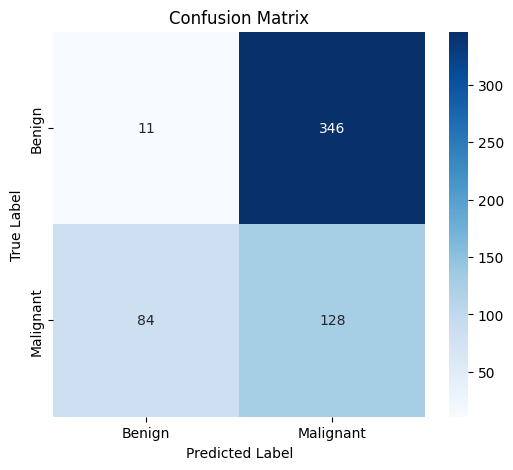

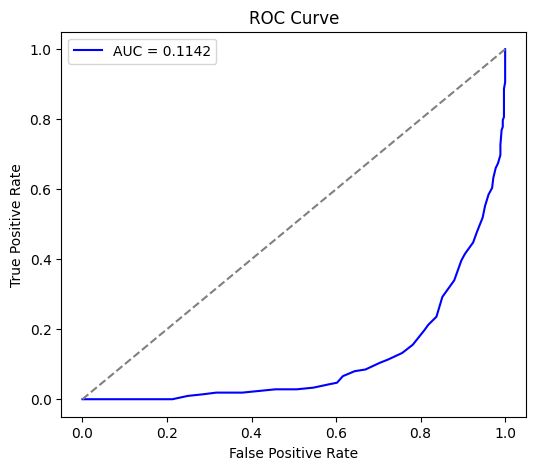

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Separate features (X) and target (y)
X_real = real_data.drop(columns=["diagnosis"])  # Drop diagnosis from features
y_real = real_data[["diagnosis"]]  # Keep diagnosis as the target

X_synth = first_data.drop(columns=["diagnosis"])  # Drop diagnosis from features
y_synth = first_data[["diagnosis"]]  # Keep diagnosis as the target

# Encode 'diagnosis' in the target variable
le = LabelEncoder()
y_real["diagnosis"] = le.fit_transform(y_real["diagnosis"])
y_synth["diagnosis"] = le.transform(y_synth["diagnosis"])  # Use the same encoder


# Train model
multi_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
multi_rf.fit(X_synth, y_synth)

# Predict
y_pred = multi_rf.predict(X_real)

print("Model training and prediction successful!")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_1 = mean_squared_error(y_real, y_pred)
mae_1 = mean_absolute_error(y_real, y_pred)
r2_1 = r2_score(y_real, y_pred)

print(f"Multi-Output Model MAE: {mae_1:.4f}")
print(f"Multi-Output Model r2: {r2_1:.4f}")
print(f"Mean Squared Error (MSE): {mse_1:.4f}")

import scipy.stats

correlation_1, _ = scipy.stats.pearsonr(y_real.values.flatten(), y_pred.flatten())
print(f"Pearson Correlation: {correlation_1:.4f}")

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert continuous predictions into binary classes (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute accuracy
accuracy_1 = accuracy_score(y_real, y_pred_classes)

# Compute AUC Score
auc_score_1 = roc_auc_score(y_real, y_pred)

# Print classification metrics
print(f"Model Accuracy: {accuracy_1:.4f}")
print(f"Model AUC Score: {auc_score_1:.4f}\n")
print("Classification Report:\n", classification_report(y_real, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_real, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_real, y_pred)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc_score_1:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



Model training and prediction successful!
Multi-Output Model MAE: 0.0923
Multi-Output Model r2: 0.8140
Mean Squared Error (MSE): 0.0435
Pearson Correlation: 0.9032
Model Accuracy: 0.9420
Model AUC Score: 0.9844

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       357
           1       0.90      0.94      0.92       212

    accuracy                           0.94       569
   macro avg       0.94      0.94      0.94       569
weighted avg       0.94      0.94      0.94       569



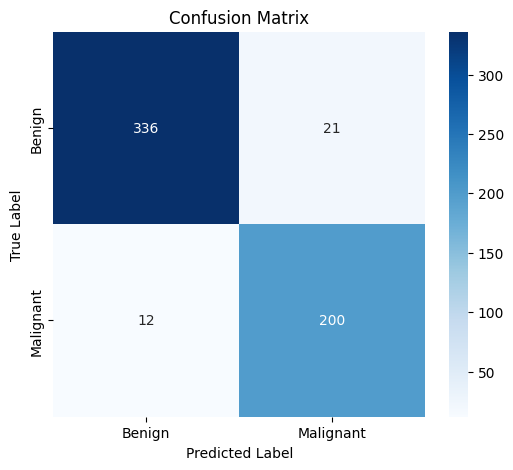

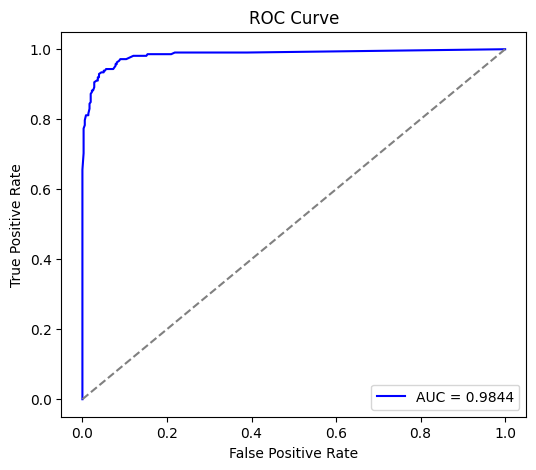

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Separate features (X) and target (y)
X_real = real_data.drop(columns=["diagnosis"])  # Drop diagnosis from features
y_real = real_data[["diagnosis"]]  # Keep diagnosis as the target

X_synth = second_data.drop(columns=["diagnosis"])  # Drop diagnosis from features
y_synth = second_data[["diagnosis"]]  # Keep diagnosis as the target

# Encode 'diagnosis' in the target variable
le = LabelEncoder()
y_real["diagnosis"] = le.fit_transform(y_real["diagnosis"])
y_synth["diagnosis"] = le.transform(y_synth["diagnosis"])  # Use the same encoder

# Train model
multi_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
multi_rf.fit(X_synth, y_synth)

# Predict
y_pred = multi_rf.predict(X_real)

print("Model training and prediction successful!")


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_2 = mean_squared_error(y_real, y_pred)
mae_2 = mean_absolute_error(y_real, y_pred)
r2_2 = r2_score(y_real, y_pred)

print(f"Multi-Output Model MAE: {mae_2:.4f}")
print(f"Multi-Output Model r2: {r2_2:.4f}")
print(f"Mean Squared Error (MSE): {mse_2:.4f}")

import scipy.stats

correlation_2, _ = scipy.stats.pearsonr(y_real.values.flatten(), y_pred.flatten())
print(f"Pearson Correlation: {correlation_2:.4f}")

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert continuous predictions into binary classes (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute accuracy
accuracy_2 = accuracy_score(y_real, y_pred_classes)

# Compute AUC Score
auc_score_2 = roc_auc_score(y_real, y_pred)

# Print classification metrics
print(f"Model Accuracy: {accuracy_2:.4f}")
print(f"Model AUC Score: {auc_score_2:.4f}\n")
print("Classification Report:\n", classification_report(y_real, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_real, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_real, y_pred)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc_score_2:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



Model training and prediction successful!
Multi-Output Model MAE: 0.2453
Multi-Output Model r2: 0.6031
Mean Squared Error (MSE): 0.0928
Pearson Correlation: 0.8060
Model Accuracy: 0.8981
Model AUC Score: 0.9597

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       357
           1       0.94      0.77      0.85       212

    accuracy                           0.90       569
   macro avg       0.91      0.87      0.89       569
weighted avg       0.90      0.90      0.90       569



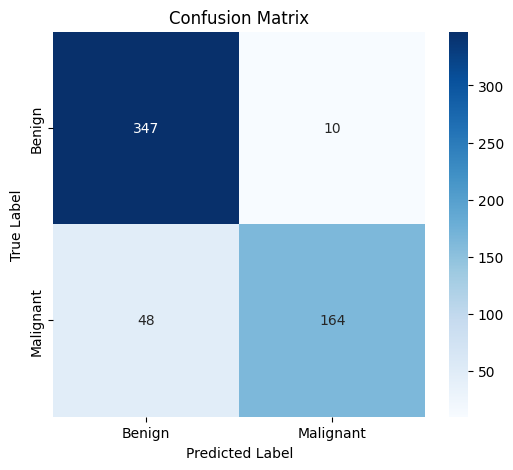

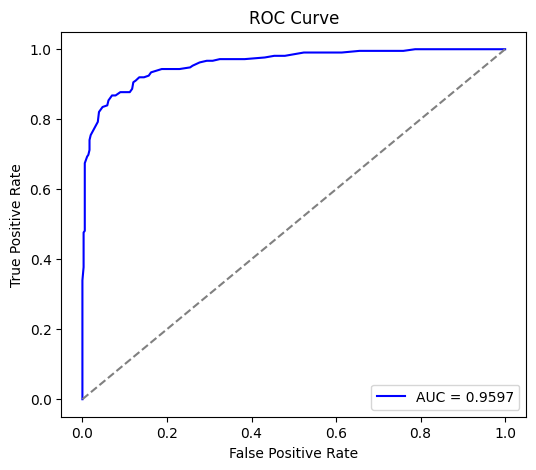

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Drop 'Regions' column if it exists
if "Regions" in real_data.columns:
    real_data = real_data.drop(columns=["Regions"])
if "Regions" in third_data.columns:
    third_data = third_data.drop(columns=["Regions"])

# Separate features (X) and target (y)
X_real = real_data.drop(columns=["diagnosis"])  # Drop diagnosis from features
y_real = real_data[["diagnosis"]]  # Keep diagnosis as the target

X_synth = third_data.drop(columns=["diagnosis"])  # Drop diagnosis from features
y_synth = third_data[["diagnosis"]]  # Keep diagnosis as the target

# Encode 'diagnosis' in the target variable
le = LabelEncoder()
y_real["diagnosis"] = le.fit_transform(y_real["diagnosis"])
y_synth["diagnosis"] = le.transform(y_synth["diagnosis"])  # Use the same encoder

# Train model
multi_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
multi_rf.fit(X_synth, y_synth)

# Predict
y_pred = multi_rf.predict(X_real)

print("Model training and prediction successful!")


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_3 = mean_squared_error(y_real, y_pred)
mae_3 = mean_absolute_error(y_real, y_pred)
r2_3 = r2_score(y_real, y_pred)

print(f"Multi-Output Model MAE: {mae_3:.4f}")
print(f"Multi-Output Model r2: {r2_3:.4f}")
print(f"Mean Squared Error (MSE): {mse_3:.4f}")

import scipy.stats

correlation_3, _ = scipy.stats.pearsonr(y_real.values.flatten(), y_pred.flatten())
print(f"Pearson Correlation: {correlation_3:.4f}")

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert continuous predictions into binary classes (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute accuracy
accuracy_3 = accuracy_score(y_real, y_pred_classes)

# Compute AUC Score
auc_score_3 = roc_auc_score(y_real, y_pred)

# Print classification metrics
print(f"Model Accuracy: {accuracy_3:.4f}")
print(f"Model AUC Score: {auc_score_3:.4f}\n")
print("Classification Report:\n", classification_report(y_real, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_real, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_real, y_pred)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc_score_3:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



In [ ]:
import pandas as pd

# Organize the values into a DataFrame including Correlation values
metrics_data = {
    "MAE": [mae_1, mae_2, mae_3],
    "R²": [r2_1, r2_2, r2_3],
    "MSE": [mse_1, mse_2, mse_3],
    "Pearson Correlation": [correlation_1, correlation_2, correlation_3],
    "Wasserstein Distance": [avg_wd_1, avg_wd_2, avg_wd_3],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3],
    "AUC Score": [auc_score_1, auc_score_2, auc_score_3]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data, index=["CTGAN", "TVAE", "GCVAE"])

# Display the table
from IPython.display import display
print("Evaluation Metrics Across Datasets for Breast Cancer:")
display(metrics_df)


Evaluation Metrics Across Datasets for Breast Cancer:


,MAE,R²,MSE,Pearson Correlation,Wasserstein Distance,Accuracy,AUC Score
CTGAN,0.636977,-0.866442,0.436309,-0.644251,22.066952,0.244288,0.114232
TVAE,0.092302,0.814044,0.043470,0.903179,8.394126,0.942004,0.984422
GCVAE,0.245325,0.603092,0.092783,0.805961,3.761204,0.898067,0.959701


In [ ]:
dupes = pd.merge(real_data, first_data, how='inner')
print(f"Exact overlap rows (CTGAN): {len(dupes)}")
dupes = pd.merge(real_data, second_data, how='inner')
print(f"Exact overlap rows (TVAE): {len(dupes)}")
dupes = pd.merge(real_data, third_data, how='inner')
print(f"Exact overlap rows (GCVAE): {len(dupes)}")

Exact overlap rows (CTGAN): 0
Exact overlap rows (TVAE): 0
Exact overlap rows (GCVAE): 0
